[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmickevicius/mcwBiophysicsMriCourse/phaseAndFrequencyEncoding.ipynb)

In [2]:
%matplotlib inline
import numpy as np
from ipywidgets import interact, interactive, FloatSlider, IntSlider
from IPython.display import clear_output, display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# Using Gradients to Locally Change Frequency

Starting with the Larmor equation:
$\omega = \gamma B$

With the gradient coils built into the scanner, we have the ability to change the magnetic field strength linearly as a function of the $x$, $y$, or $z$ axes.

The Larmor equation then describes a spatially dependent frequency as:
$\omega (y) = \gamma G y$.


In [2]:
def plotGrad(G, gammaBar):

    yvec = np.linspace(-0.12, 0.12, 100)
    f = gammaBar * G * 1e-3 * yvec * 1e-3
    fmax = yvec[-1] * 0.04 * 42.58e06 * 1e-3

    plt.figure()
    plt.plot(yvec, f)
    plt.xlabel('$y$ Position [m]')
    plt.ylabel('$f$ Larmor Frequency [kHz]')
    plt.ylim([-fmax, fmax])
    plt.grid()
    plt.show()

w = interactive(plotGrad,
                G=FloatSlider(min=-40.0, max=40.0, value=0.0, description='G [mT/m]', continuous_update=False),
                gammaBar=FloatSlider(min=10e6, max=42.58e6, value=42.58e6, description='gamma [Hz/T]', continuous_update=False))
display(w)




interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='G [mT/m]', max=40.0, min=-4…

# Spin Phase

Spins tipped into the transverse plane by an RF pulse precess around the applied magnetic field.

In [7]:
def plotPhaseUnitCircle(T):

    nspins = 16
    f = np.linspace(0.0, 100.0, nspins) # Hz
    om = 2 * np.pi * f                  # Rad/s
    phi = om * T * 1e-3                 # Rad

    print(f.shape)

    # spins start aligned along x axis
    xy = np.zeros((2,nspins), dtype=np.float32)
    xy[0,:] = 1.0

    R = np.zeros((2,2), dtype=np.float32)

    plt.figure()

    for s in range(nspins):

        R[0,0] = np.cos(phi[s])
        R[0,1] = -np.sin(phi[s])
        R[1,0] = np.sin(phi[s])
        R[1,1] = np.cos(phi[s])

        xyrot = R@xy[:,s]

        plt.arrow(0.0, 0.0, xyrot[0], xyrot[1])

    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid()

    plt.show()

w = interactive(plotPhaseUnitCircle,
                T=FloatSlider(min=0.0, max=10.0, value=0.0, description='T [ms]', continuous_update=False))
display(w)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='T [ms]', max=10.0), Output(…

# Using Gradient ***PULSES*** to Locally Vary ***PHASE***

Keeping a (constant amplitude) gradient on for a fixed period of time will introduce a spatially dependent phase: $\phi (y) = \gamma G y T$

Here we will apply a gradient pulse and change its strength and duration to see the phase accrued as a function of position along the gradient axis.

In [8]:
def plotGradPulse(G, T):

    gammaBar = 42.58e06
    tvec = np.linspace(0.0, 1.0, 100)
    gwav = G*np.ones((tvec.size,))
    gwav[tvec >= T] = 0.0
    gwav[0] = 0.0
    gwav[-1] = 0.0

    yvec = np.linspace(-0.12, 0.12, 512)
    f = gammaBar * G * 1e-3 * yvec
    ph = f * T * 1e-3

    plt.figure(figsize=(8,4))

    # Plot Gx
    plt.subplot(121)
    plt.plot(tvec, gwav)
    plt.ylabel('$G$ [mT/m]')
    plt.xlabel('$Time$ [ms]')
    plt.ylim([-20, 50])
    plt.grid()

    plt.subplot(122)
    plt.plot(yvec, np.sin(ph))
    plt.xlabel('$y$ [m]')
    plt.ylabel('$sin(\phi)$')
    plt.ylim([-1.5, 1.5])
    plt.grid()

    plt.show()

w = interactive(plotGradPulse,
                G=FloatSlider(min=0.0, max=40.0, value=20.0, description='G [mT/m]', continuous_update=False),
                T=FloatSlider(min=0.0, max=1.0, value=0.5, description='T [ms]', continuous_update=False))
display(w)

interactive(children=(FloatSlider(value=20.0, continuous_update=False, description='G [mT/m]', max=40.0), Floa…

# Phase Encoding

From the section above, you can see that changing the ***area*** under the gradient pulse changes the number of phase cycles across the $y$ dimension. We refer to the range of $y$ values of interest as the "field-of-view".

In imaging, we choose the area under the pulse strategically to introduce a specific number of phase cycles across the FOV. This is done as follows:



In [9]:
gammaBar = 42.58e06
gamma = 2 * np.pi * gammaBar
fov = 0.24
ny = 32

delta_y = fov / ny
delta_k = 1 / fov
yv = np.arange(-ny/2, ny/2) * delta_y
kv = np.arange(-ny/2, ny/2) * delta_k

# define an array of desired number of phase cycles across imaging field of view
numCyclesAcrossFov = np.arange(-ny/2, ny/2)

# convert the cycles to phase
phaseAcrossFov = 2 * np.pi * numCyclesAcrossFov

# calculate the amplitude of a gradient pulse needed to achieve these phases
T = 0.0008 # hard-coded duration of pulse
G = phaseAcrossFov / ( gamma * fov * T)

# gradient waves for plotting purposes
tv = np.linspace(-T,T,100)
gwav = np.ones_like(tv)
gwav[np.abs(tv) > T/2] = 0.0
gwav = gwav[:,None] * G[None,:]

yvplot = np.linspace(-fov/2, fov/2, 1024)
f = gammaBar * G[None,:] * yvplot[:,None]
ph = 2 * np.pi * f * T

def plotPhaseEncodingConcept(IDX):

    plt.figure(figsize=(8,4))

    plt.subplot(121)
    plt.plot(gwav,color='k')
    plt.plot(gwav[:,IDX])

    plt.subplot(122)
    plt.plot(yvplot, np.sin(ph[:,IDX]))
    plt.xlabel('$y$ [m]')
    plt.ylabel('$sin(\phi)$')
    plt.grid()

    plt.show()

w = interactive(plotPhaseEncodingConcept,
                IDX=IntSlider(min=0, max=ny-1, value=ny/2, description='Index', continuous_update=False))
display(w)


interactive(children=(IntSlider(value=16, continuous_update=False, description='Index', max=31), Output()), _d…

# Building a Fourier Relationship

All spins precessing in the transverse plane will contribute to the voltage induced in the RF coils. This signal, demodulated at $\omega_0 = \gamma B_0$, is given by the following, where m(y) is the underlying image we are trying to measure.

$S = \int m(y) e^{i y \gamma G T} dy$

If we make the substitution $k = \frac{\gamma}{2 \pi} G T$, the signal equation becomes

$S(k) = \int m(y) e^{i 2 \pi y k} dy$

which is the equation for the Fourier transform: $S(k) = F\{ m(y)\}$

Since we measure discretized images, a more useful formalism of this relationship is as follows:

$S(n \Delta k) = \int m(y) e^{i 2 \pi y n \Delta k} dy$, where $n \in [-N/2, N/2-1]$ and $N$ is the imaging matrix size.



# One Dimensional Phase Encoding Pulse Sequence and Simulation

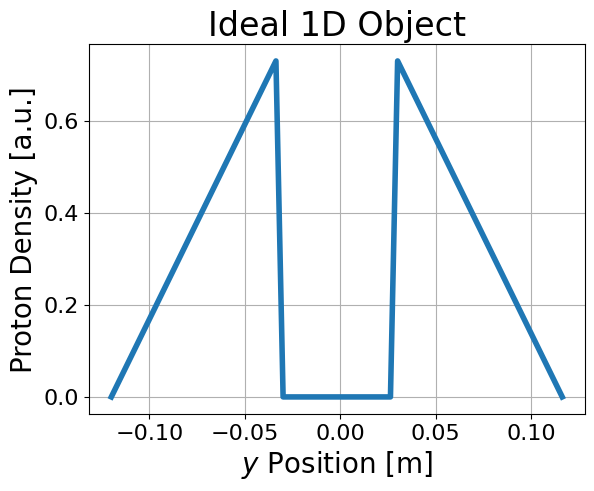

interactive(children=(IntSlider(value=1, continuous_update=False, description='Index', max=64, min=1), Output(…

In [71]:
# make the pulse sequence
gammaBar = 42.58e06
dt = 10e-6

# create ideal 1D object that we will be imaging
ny = 64
fov = 0.24
dy = fov/ny
yv = np.arange(-fov/2, fov/2, dy)
obj = 1-np.abs(np.linspace(-1, 1, ny, dtype=np.float32))
obj[np.abs(yv) < fov/8] = 0.0
plt.figure()
plt.plot(yv, obj)
plt.grid()
plt.title('Ideal 1D Object')
plt.ylabel('Proton Density [a.u.]')
plt.xlabel('$y$ Position [m]')
plt.show()
print('\n')

# phase encoding gradients
tgrad = 1e-3
ngrad = int(tgrad/dt)
dk = 1/fov
kv = np.arange(-ny/2, ny/2) * dk
G = kv / (gammaBar * tgrad)
gwav = np.zeros((ngrad+2,G.size), dtype=np.float32)
for n in range(G.size):
    gwav[1:-1,n] = G[n]

# non-selective RF pulse
flipAngle = 90
trf = 0.5e-3
nrf = int(trf/dt)
rfAmpl = flipAngle * np.pi / 180.0 / (2 * np.pi * gammaBar * trf) * 1e6 # micro Tesla
rfwav = np.zeros((nrf+2,), dtype=np.float32)
rfwav[1:-1] = rfAmpl

# for plotting pulse sequence
pad = np.zeros((int(ngrad/2),))
padg = np.zeros((int(ngrad/2),G.size))
rf = np.concatenate([rfwav, np.zeros((ngrad+2,)), pad],0)
grad = np.concatenate([np.zeros((nrf,G.size)), gwav, padg],0)

# simulate k-space
Sk = np.zeros((ny,), dtype=np.complex64)
for n in range(ny):
    Sk[n] = np.sum(obj * np.exp(-1j * 2 * np.pi * kv[n] * yv))

# center-out ordering
inds = np.arange(-ny/2, ny/2)
tmp = np.argsort(np.abs(inds))
lines = inds[tmp]
indices = (lines + ny/2).astype(np.int32)


def plotSim1d(IMAX):

    colors = plt.cm.viridis(np.linspace(0,1,ny))

    plt.figure()
    # plt.title('Pulse Sequence - Phase Encoding')

    plt.subplot(241)
    plt.plot(rf,color='k')
    plt.ylabel('RF [$\mu$T]')
    plt.grid()

    plt.subplot(245)
    for n in range(IMAX):
        plt.plot(1e3*grad[:,indices[n]],color=colors[n],linewidth=1.0)
    plt.ylim([-np.max(G)*1.1e3, np.max(G)*1.1e3])
    plt.ylabel('$G_y$ [mT/m]')
    plt.xlabel('Time')

    plt.subplot(222)
    sig = np.zeros((ny,), dtype=np.complex64)
    for n in range(IMAX):
        plt.scatter(kv[indices[n]], np.abs(Sk[indices[n]]), color=colors[n])
        sig[indices[n]] = Sk[indices[n]]
    plt.ylim([-0.1*np.max(np.abs(Sk)), 1.1*np.max(np.abs(Sk))])
    plt.xlim([np.min(kv), np.max(kv)])
    plt.xlabel('k-Space [1/m]')
    plt.ylabel('$|S(k)|$ [a.u.]')
    plt.grid()

    # reconstruct with inverse FFT
    rec = np.abs(np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(sig))))
    plt.subplot(224)
    plt.plot(rec)
    plt.grid()
    plt.ylabel('Reconstruction')
    plt.ylim([0.0, 1.1*np.max(np.abs(obj))])


    plt.show()

w = interactive(plotSim1d,
                IMAX=IntSlider(min=1, max=ny, value=1, description='Index', continuous_update=False))
display(w)
